In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from numpy import load
import math
%matplotlib inline

In [2]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [3]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

In [245]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [5]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()

lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
        
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)

last date without full 51 states:  2020-03-06


In [6]:
actual_cases_testing = pd.read_csv('data/all-states-history_till_MARCH.csv')[['date','state','positiveIncrease']]
actual_cases_testing = actual_cases_testing[actual_cases_testing['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases_testing['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases_testing[actual_cases_testing.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases_testing = actual_cases_testing[actual_cases_testing.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)
print("max day is", max(actual_cases_testing.date))

last date without full 51 states:  2020-03-06
max day is 2021-03-07


In [7]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 
             'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 
             'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)
assert NUM_SYMP == 17, "NUM SYMP ERROR"

In [8]:
BORDER_DICT = {
    'US-AK': [],
    'US-AL': ['US-MI', 'US-TN', 'US-GA', 'US-FL'],
    'US-AR': ['US-OK', 'US-TX', 'US-MO', 'US-TN', 'US-MS', 'US-LA'],
    'US-AZ': ['US-NM', 'US-UT', 'US-NV', 'US-CA'],
    'US-CA': ['US-OR', 'US-NV', 'US-AZ'],
    'US-CO': ['US-WY', 'US-NE', 'US-KS', 'US-OK', 'US-NM', 'US-UT'],
    'US-CT': ['US-RI', 'US-MA', 'US-NY'],
    'US-DC': ['US-MD', 'US-VA'],
    'US-DE': ['US-PA', 'US-NJ', 'US-MD'],
    'US-FL': ['US-AL', 'US-GA'],
    'US-GA': ['US-FL', 'US-AL', 'US-TN', 'US-NC', 'US-SC'],
    'US-HI': [],
    'US-IA': ['US-MN', 'US-WI', 'US-IL', 'US-MO', 'US-NE', 'US-SD'],
    'US-ID': ['US-OR', 'US-NV', 'US-UT', 'US-WY', 'US-MT', 'US-WA'],
    'US-IL': ['US-IA', 'US-MO', 'US-KY', 'US-IN', 'US-WI'],
    'US-IN': ['US-MI', 'US-OH', 'US-KY', 'US-LI'],
    'US-KS': ['US-CO', 'US-NE', 'US-MO', 'US-OK'],
    'US-KY': ['US-IL', 'US-IN', 'US-OH', 'US-WV', 'US-VA', 'US-TN', 'US-MO'],
    'US-LA': ['US-TX', 'US-AR', 'US-MS'],
    'US-MA': ['US-NH', 'US-VT', 'US-NY', 'US-RI', 'US-CT'],
    'US-MD': ['US-DE', 'US-VA', 'US-WV', 'US-PA'],
    'US-ME': ['US-NH'],
    'US-MI': ['US-WI', 'US-IN', 'US-OH'],
    'US-MN': ['US-ND', 'US-SD', 'US-IA', 'US-WI'],
    'US-MO': ['US-IA', 'US-IL', 'US-KY', 'US-TN', 'US-AR', 'US-OK', 'US-KS', 'US-NE'], 
    'US-MS': ['US-AL', 'US-TN', 'US-AR', 'US-LA'],
    'US-MT': ['US-ID', 'US-WY', 'US-SD', 'US-ND'],
    'US-NC': ['US-VA', 'US-TN', 'US-GA', 'US-SC'],
    'US-ND': ['US-MT', 'US-SD', 'US-MN'],
    'US-NE': ['US-SD', 'US-IA', 'US-MO', 'US-KS', 'US-CO', 'US-WY'],
    'US-NH': ['US-ME', 'US-VT', 'US-MA'],
    'US-NJ': ['US-PA', 'US-DE', 'US-NY'],
    'US-NM': ['US-AZ', 'US-CO', 'US-OK', 'US-TX'],
    'US-NV': ['US-CA', 'US-OR', 'US-ID', 'US-UT', 'US-AZ'],
    'US-NY': ['US-VT', 'US-MA', 'US-CT', 'US-NJ', 'US-PA'],
    'US-OH': ['US-MI', 'US-IN', 'US-KY', 'US-WV', 'US-PA'],
    'US-OK': ['US-TX', 'US-AR', 'US-MO', 'US-KS', 'US-CO', 'US-NM'],
    'US-OR': ['US-WA', 'US-ID', 'US-NV', 'US-CA'],
    'US-PA': ['US-NJ', 'US-NY', 'US-DE', 'US-MD', 'US-WV', 'US-OH'], 
    'US-RI': ['US-MA', 'US-CT'],
    'US-SC': ['US-NC', 'US-GA'],
    'US-SD': ['US-ND', 'US-MN', 'US-IA', 'US-NE', 'US-WY', 'US-MT'], 
    'US-TN': ['US-KY', 'US-VA', 'US-NC', 'US-GA', 'US-AL', 'US-MS', 'US-AR', 'US-MO'],
    'US-TX': ['US-NM', 'US-OK', 'US-AR', 'US-LA'],
    'US-UT': ['US-NV', 'US-AZ', 'US-CO', 'US-WY', 'US-ID'],
    'US-VA': ['US-WV', 'US-MD', 'US-KY', 'US-TN', 'US-NC'], 
    'US-VT': ['US-NH', 'US-MA', 'US-NY'],
    'US-WA': ['US-OR', 'US-ID'],
    'US-WI': ['US-MI', 'US-IL', 'US-IA', 'US-MN'],
    'US-WV': ['US-OH', 'US-PA', 'US-MD', 'US-VA'],
    'US-WY': ['US-ID', 'US-MT', 'US-SD', 'US-NE', 'US-CO', 'US-UT']
}

In [78]:
def get_date(date):
    date_elems = [int(elem) for elem in date.split('-')]
    return datetime.datetime(date_elems[0], date_elems[1], date_elems[2])

def prepare_date_range(start_date, end_date):
    start = get_date(start_date) + datetime.timedelta(days=-1)
    end = get_date(end_date)
    date_range = list(pd.date_range(start, end))
    date_range = [date.strftime('%Y-%m-%d') for date in date_range]
    return date_range

In [79]:
NEW_NUM_SYMP = 1
def new_delta_mat(delta_mat, period, idx_symp1, idx_symp2):
    new_delta_mat = np.zeros((period, NUM_STATES))
    for idx_d in range(period):
        delta_day = delta_mat[idx_d]
        delta_symp_1_2 = np.array([ np.multiply(delta_region[idx_symp1], delta_region[idx_symp2]) for delta_region in delta_day])
        new_delta_mat[idx_d] = delta_symp_1_2
    return new_delta_mat

## L HAT

In [80]:
def std_dev_delta(delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def L_score(delta_mat, std_mat, period, mult):
    L = np.zeros((period, NUM_STATES))
    for idx_d, delta_day in enumerate(delta_mat):
        L_score = delta_day > (mult*std_mat)
        L[idx_d] = L_score.astype(int)
    return L

In [81]:
def pred_outbreak_detection(delta_mat, period, mult):
    std_mat = std_dev_delta(delta_mat)
    l_score = L_score(delta_mat, std_mat, period, mult)
    return l_score

# L

In [82]:
def covid_case_outbreak_detection_all(X, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    period = len(X_target) 
    C = np.zeros(period)
    
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide( np.subtract(X_day, X_target[idx-1]) , X_target[idx-1])
        C[idx] = Cd
        
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)
    L_score = C > (2 * std_C)
    return L_score.astype(int)

# Comparison

In [83]:
def get_target_region_idx(target_region):
    i, = np.where(STATES == target_region)
    return i.item()

def window_L(L, lag, period_L_hat):
    idx = np.arange(lag, lag + period_L_hat)
    L_window = L[idx]
    return L_window

def comparison_all(target_region, L, L_hat, lag):
    target_reg_idx = get_target_region_idx(target_region)
    
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    assert len(L_hat_region) == period, "L_hat_region size issue"
    
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            date_idx_L_outbreaks = w[L_outbreaks]
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

In [84]:
def metrics(S, L_window):
    TP_FP = np.sum(S, axis=0)
    FN = np.sum(L_window) - TP_FP[0]
    precision = TP_FP[0] / (TP_FP[0] + TP_FP[1])
    recall = TP_FP[0] / (TP_FP[0] + FN)
    Fscore = 2 * ((precision * recall) / (precision + recall))
    return TP_FP, FN, precision, recall, Fscore

In [85]:
actual_all = actual_cases[(actual_cases.date >= '2020-03-01') & (actual_cases.date <= '2021-02-23')]
print("L:", min(actual_all.date) + " - " + max(actual_all.date))

L: 2020-03-07 - 2021-02-23


# Smoothing data

In [86]:
Mar_smooth = load('results/smoothing_delta/sMar20_01_31.npy')
Apr_smooth = load('results/smoothing_delta/sApr20_01_30.npy')
May_smooth = load('results/smoothing_delta/sMay20_01_31.npy')
Jun_smooth = load('results/smoothing_delta/sJun20_01_30.npy')
Jul_smooth = load('results/smoothing_delta/sJul20_01_31.npy')
Aug_smooth = load('results/smoothing_delta/sAug20_01_31.npy')
Sept_smooth = load('results/smoothing_delta/sSept20_01_30.npy')
Oct_smooth = load('results/smoothing_delta/sOct20_01_31.npy')
Nov_smooth = load('results/smoothing_delta/sNov20_01_30.npy')
Dec_smooth = load('results/smoothing_delta/sDec20_01_31.npy')

period_31 = Mar_smooth.shape[0]
period_30 = Apr_smooth.shape[0]

In [87]:
new_delta_sMar = new_delta_mat(Mar_smooth, period_31, 4, 7)[6:]
new_delta_sApr = new_delta_mat(Apr_smooth, period_30, 4, 7)
new_delta_sMay = new_delta_mat(May_smooth, period_31, 4, 7)
new_delta_sJun = new_delta_mat(Jun_smooth, period_30, 4, 7)
new_delta_sJul = new_delta_mat(Jul_smooth, period_31, 4, 7)
new_delta_sAug = new_delta_mat(Aug_smooth, period_31, 4, 7)
new_delta_sSept = new_delta_mat(Sept_smooth, period_30, 4, 7)
new_delta_sOct = new_delta_mat(Oct_smooth, period_31, 4, 7)
new_delta_sNov = new_delta_mat(Nov_smooth, period_30, 4, 7)
new_delta_sDec = new_delta_mat(Dec_smooth, period_31, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta = np.concatenate((new_delta_sMar, new_delta_sApr), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sMay), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJun), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJul), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sAug), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sSept), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sOct), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sNov), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sDec), axis=0)

L_hat_period = new_Sdelta.shape[0]
print(L_hat_period, "days")

300 days


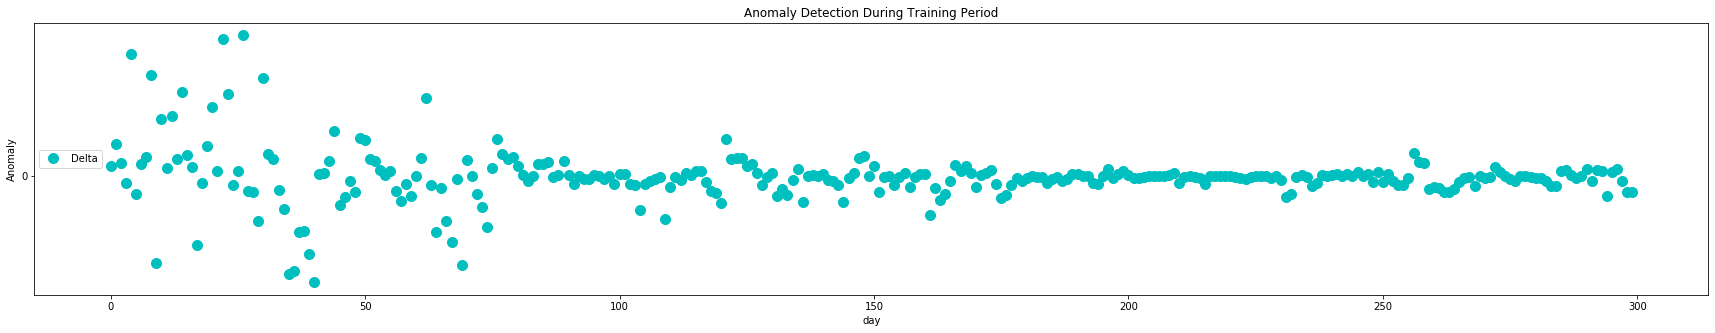

In [88]:
# precision, recall, Fscore
CT = get_target_region_idx("US-CT")
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(L_hat_period)), new_Sdelta.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Delta")
ax.legend(loc="center left")

In [112]:
# return TP_FP, FN, precision, recall, Fscore
mult = np.arange(1,4,0.5)
lag = np.arange(0,30)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.array([1,0])
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    
    for m in mult:
        for idx_l, l in enumerate(lag):   
            L_hat = pred_outbreak_detection(new_Sdelta, L_hat_period, m)
            all_S, L_window = comparison_all(state, L, L_hat, l)    
            metr = metrics(all_S, L_window)
            if metr[4] > best_f_score:
                best_th_lag[0] = m
                best_th_lag[1] = l
                best_f_score = metr[4]   
    state_best_th_lag[idx_s] = best_th_lag

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [113]:
state_TP_FP_S = np.zeros((NUM_STATES,2))
state_FN_S = np.zeros(NUM_STATES)
state_fscore_S = np.zeros(NUM_STATES)
state_precision_S = np.zeros(NUM_STATES)
state_recall_S = np.zeros(NUM_STATES)

total_real_anomalies_S = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
    L_hat_S = pred_outbreak_detection(new_Sdelta, L_hat_period, state_best_th_lag[idx_s][0])
    all_S_smooth, L_window_S = comparison_all(state, L_S, L_hat_S, int(state_best_th_lag[idx_s][1]))
    
    total_real_anomalies_S[idx_s] = np.sum(L_window_S)
    metr = metrics(all_S_smooth, L_window_S)
    state_TP_FP_S[idx_s] = metr[0]
    state_FN_S[idx_s] = metr[1]
    state_precision_S[idx_s] = metr[2]
    state_recall_S[idx_s] = metr[3]
    state_fscore_S[idx_s] = metr[4]

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [119]:
np.savetxt("state_TP_FP_S.csv", state_TP_FP_S, delimiter=",")
np.savetxt("state_FN_S.csv", state_FN_S, delimiter=",")
np.savetxt("state_precision_S.csv", state_precision_S, delimiter=",")
np.savetxt("state_recall_S.csv", state_recall_S, delimiter=",")
np.savetxt("state_fscore_S.csv", state_fscore_S, delimiter=",")
np.savetxt("total_real_anomalies_S.csv", total_real_anomalies_S, delimiter=",")
np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

### Analysis of results

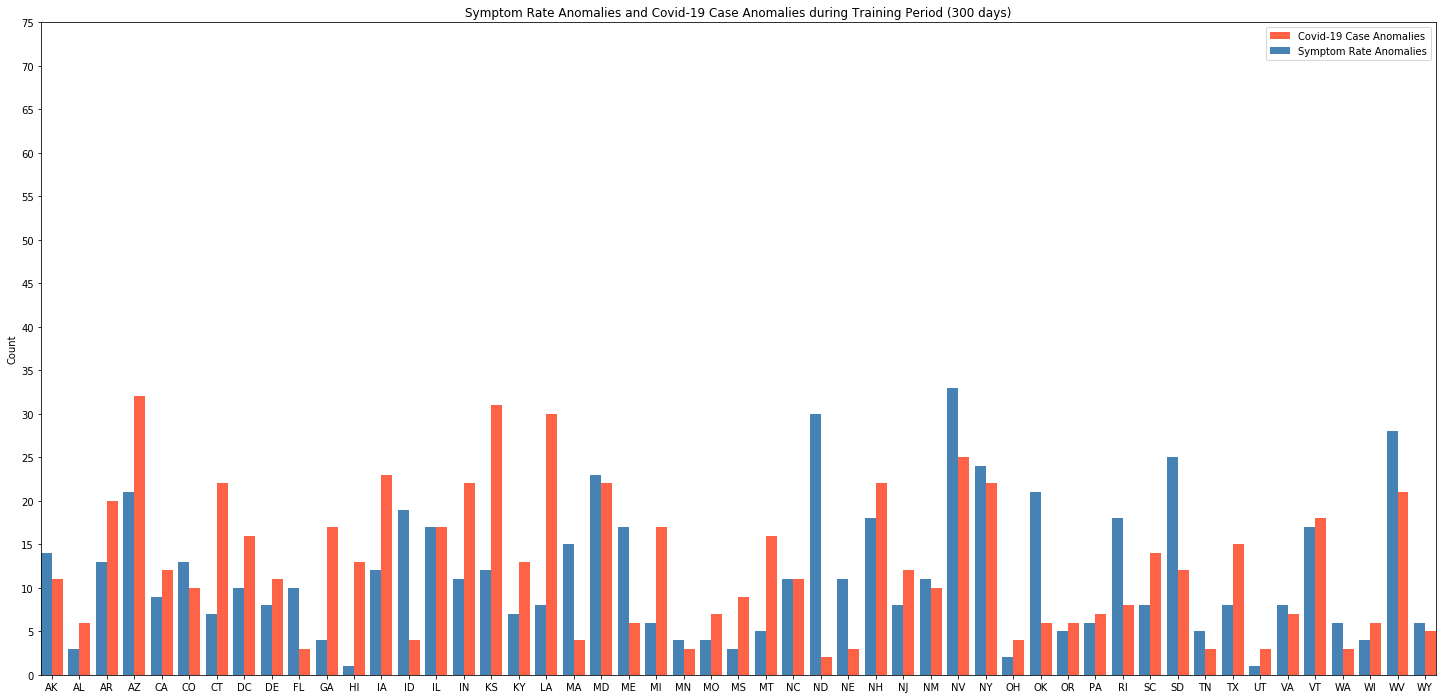

In [123]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(51)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(real_anoms) for real_anoms in total_real_anomalies_S], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

### State Level

1.0


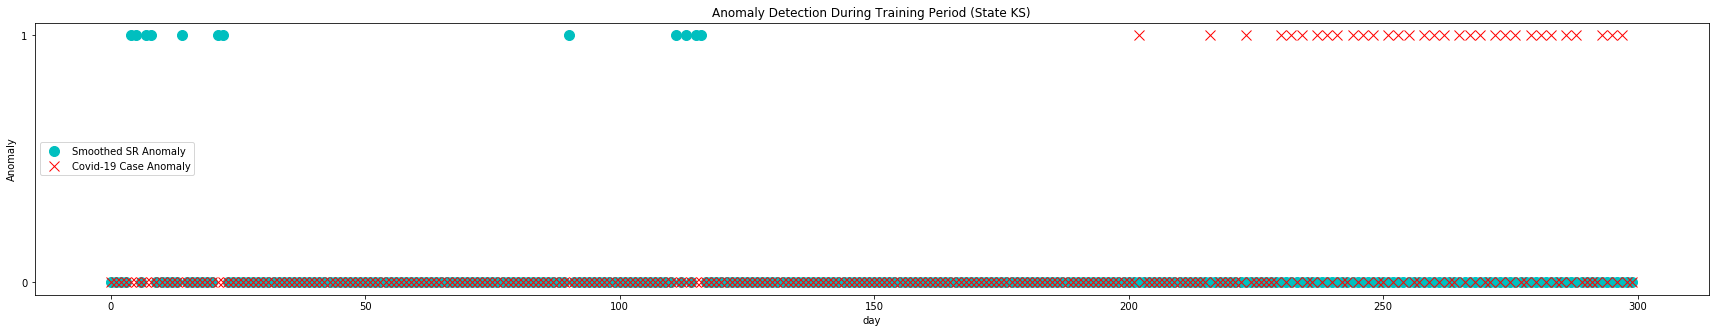

In [343]:
ND = get_target_region_idx("US-KS")

# precision, recall, Fscore
state_th = state_best_th_lag[ND][0]
state_lag = 3
print(state_th)
L_ND = covid_case_outbreak_detection_all(actual_all, "KS")
L_hat_ND = pred_outbreak_detection(new_Sdelta, L_hat_period, state_th)
ND_S, L_window_ND = comparison_all("US-KS", L_ND, L_hat_ND, int(state_lag))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period (State KS)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(L_hat_period)), L_hat_ND.transpose()[ND], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(L_hat_period)), L_window_ND, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

0.14001540270432747
0.04352770126994117


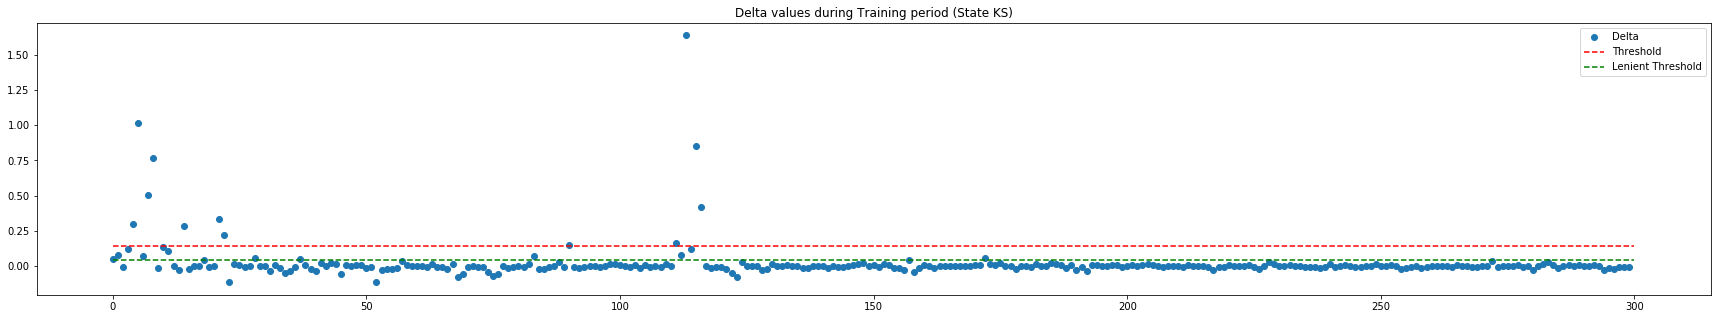

In [362]:
std_ND = std_dev_delta(new_Sdelta)[ND]
print(std_ND)
temp_delta = np.copy(new_Sdelta.transpose()[ND])
temp_delta[temp_delta > 3*std_ND] = 0
std_ND2 = np.std(temp_delta)
print(std_ND2)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.plot(new_Sdelta.transpose()[ND],  marker='o', linewidth=0, label="Delta")
ax.plot([0, 300], [std_ND, std_ND], c='r', linestyle='--', label="Threshold")
ax.plot([0, 300], [std_ND2, std_ND2], c='g', linestyle='--', label="Lenient Threshold")
# ax.plot([0, 300], [2*std_ND, 2*std_ND], c='g', linestyle='--', label="2xThreshold")
ax.set_title("Delta values during Training period (State KS)")
ax.legend()

No handles with labels found to put in legend.


Text(0, 0.5, 'Positive Cases')

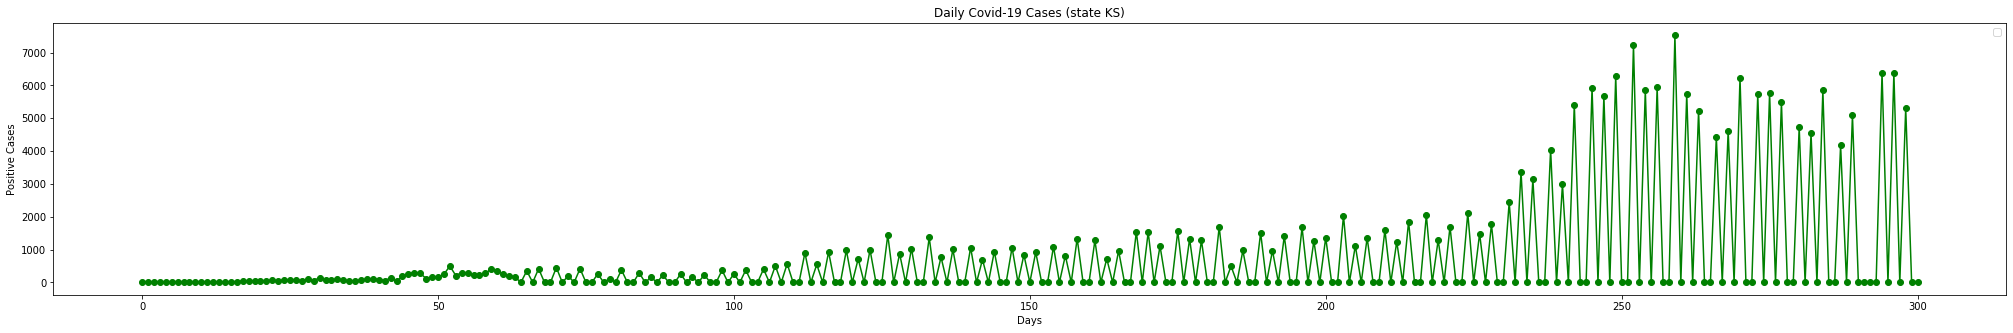

In [367]:
actual_ND = actual_all[actual_all.state == "KS"].sort_values(by='date')['positiveIncrease'].to_numpy()[2:303]
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(35)
ax.plot(actual_ND, marker='o', color='g')
# ax.plot(c[:300],  marker='o', linewidth=0, label="Delta")
ax.set_title("Daily Covid-19 Cases (state KS)")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Positive Cases")

Text(0.5, 1.0, 'Relative Change, C, in Covid-19 Cases (State KS)')

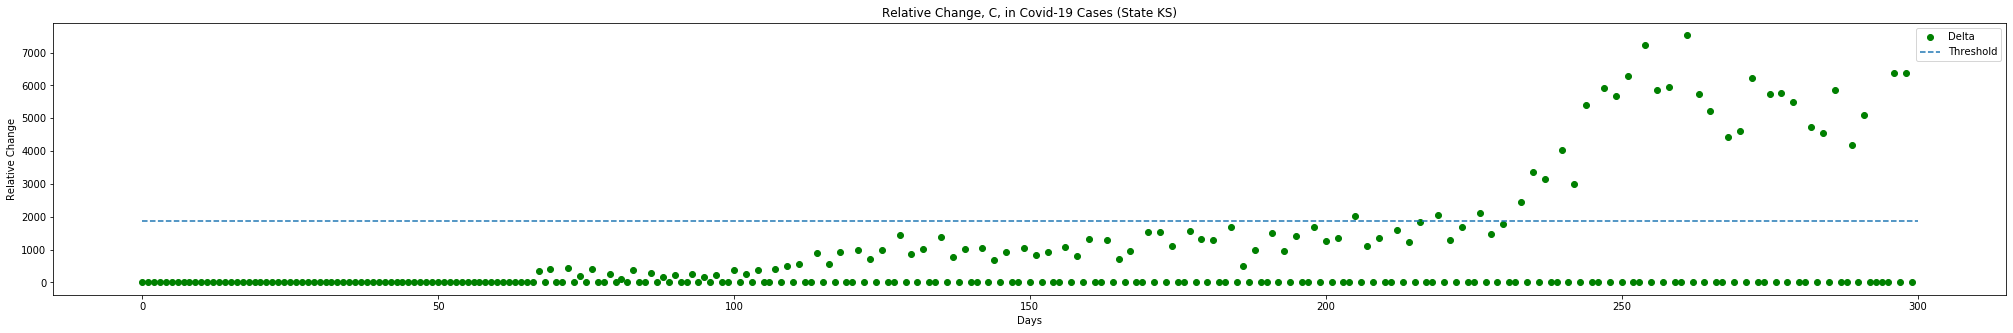

In [382]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(35)
ax.plot(relative_change[:300],  marker='o', color='g',linewidth=0, label="Delta")
ax.plot([0, 300], [threshold_std, threshold_std], linestyle='--', label="Threshold")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Relative Change")
ax.set_title("Relative Change, C, in Covid-19 Cases (State KS)")

In [349]:
def L_with_std(X, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    period = len(X_target) 
    C = np.zeros(period)
    
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide( np.subtract(X_day, X_target[idx-1]) , X_target[idx-1])
        C[idx] = Cd
        
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)
    L_score = C > (2 * std_C)
    return L_score.astype(int), 2*std_C, C

L_stateND, threshold_std, relative_change = L_with_std(actual_all, "KS")
L_stateND_window = window_L(L_stateND, 0, 300)

In [383]:
print(C)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.00000000e+00
  8.00000000e-01 -4.44444444e-01  6.00000000e-01 -8.75000000e-01
  1.00000000e+00  5.00000000e-01  1.00000000e+00  1.16666667e+00
 -3.07692308e-01  1.11111111e+00 -1.05263158e-01 -4.11764706e-01
  0.00000000e+00  1.20000000e+00 -9.09090909e-02 -3.00000000e-01
 -7.14285714e-02  6.15384615e-01 -1.42857143e-01 -3.33333333e-01
  1.66666667e-01  2.85714286e-01 -5.00000000e-01  6.66666667e-01
  0.00000000e+00  5.33333333e-01 -5.65217391e-01  1.30000000e+00
  2.17391304e-01  6.42857143e-01  9.56521739e-01 -3.77777778e-01
 -2.50000000e-01 -5.71428571e-01  8.33333333e-01 -3.03030303e-02
  1.87500000e-01  4.73684211e-01  1.42857143e-01  1.71875000e-01
 -3.46666667e-01 -1.42857143e-01 -1.90476190e-01  1.76470588e-01
  1.50000000e-01 -1.73913043e-01 -1.05263158e-01  1.47058824e-01
  4.35897436e-01 -1.25000

In [355]:
std1 = np.std(relative_change)

temp = np.copy(relative_change)
temp[temp > (3 * std1)] = 0
std2 = np.std(temp)

2*std2


1881.9588532003609

# Smoothing 2: Without March, April

In [52]:
# Joining of new delta: 7th Mar - Jan 2021
# new_Sdelta_small = np.concatenate((new_delta_sApr, new_delta_sMay), axis=0)
new_Sdelta_small = np.concatenate((new_delta_sMay, new_delta_sJun), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sJul), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sAug), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sSept), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sOct), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sNov), axis=0)
new_Sdelta_small = np.concatenate((new_Sdelta_small, new_delta_sDec), axis=0)

L_hat_period_small = new_Sdelta_small.shape[0]
print(L_hat_period_small, "days")

actual_all_small = actual_cases[(actual_cases.date >= '2020-05-01') & (actual_cases.date <= '2021-03-31')]
print("L:", min(actual_all_small.date) + " - " + max(actual_all_small.date))

245 days
L: 2020-05-01 - 2021-02-25


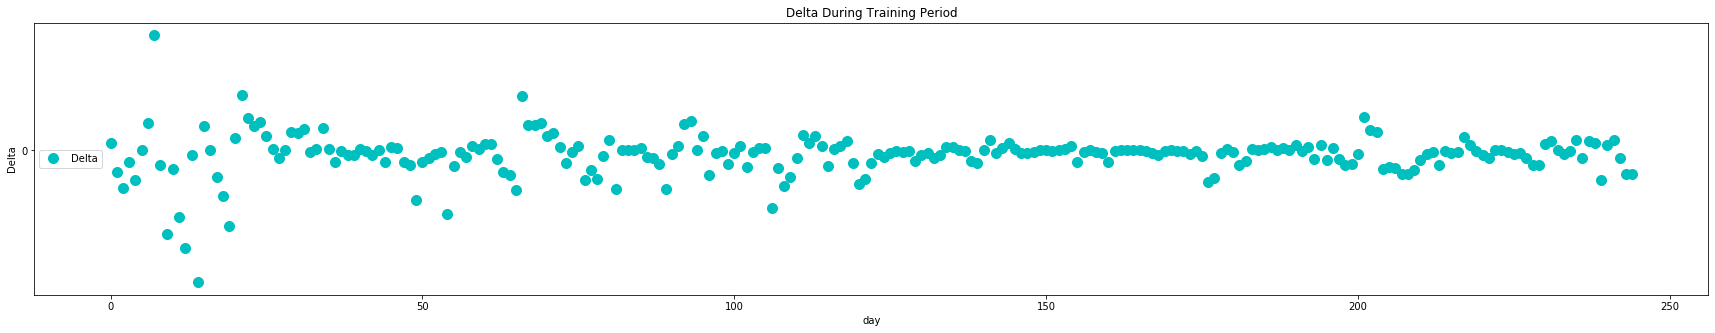

In [53]:
# precision, recall, Fscore
CT = get_target_region_idx("US-CT")

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Delta")
ax.set_xlabel("day")
ax.set_title("Delta During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(L_hat_period_small)), new_Sdelta_small.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Delta")
ax.legend(loc="center left")

In [54]:
# return TP_FP, FN, precision, recall, Fscore
mult = np.arange(1,4,0.5)
lag = np.arange(0,30)
small_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    
    L = covid_case_outbreak_detection_all(actual_all_small, target)
    for m in mult:
        for idx_l, l in enumerate(lag):   
            
            L_hat_small = pred_outbreak_detection(new_Sdelta_small, L_hat_period_small, m)
            all_S_small, L_window_small = comparison_all(state, L, L_hat_small, l)   
            
            metr = metrics(all_S_small, L_window_small)
            if metr[4] > best_f_score:
                best_th_lag[0] = m
                best_th_lag[1] = l
                best_f_score = metr[4]   
    small_best_th_lag[idx_s] = best_th_lag

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [93]:
small_TP_FP_S = np.zeros((NUM_STATES,2))
small_FN_S = np.zeros(NUM_STATES)
small_fscore_S = np.zeros(NUM_STATES)
small_precision_S = np.zeros(NUM_STATES)
small_recall_S = np.zeros(NUM_STATES)
total_real_anomalies_S = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    
    L_S = covid_case_outbreak_detection_all(actual_all_small, target)
    L_hat_S = pred_outbreak_detection(new_Sdelta_small, L_hat_period_small, small_best_th_lag[idx_s][0])
    all_S_smooth, L_window_S = comparison_all(state, L_S, L_hat_S, int(small_best_th_lag[idx_s][1]))
    
    total_real_anomalies_S[idx_s] = np.sum(L_window_S)
    metr = metrics(all_S_smooth, L_window_S)
    small_TP_FP_S[idx_s] = metr[0]
    small_FN_S[idx_s] = metr[1]
    small_precision_S[idx_s] = metr[2]
    small_recall_S[idx_s] = metr[3]
    small_fscore_S[idx_s] = metr[4]

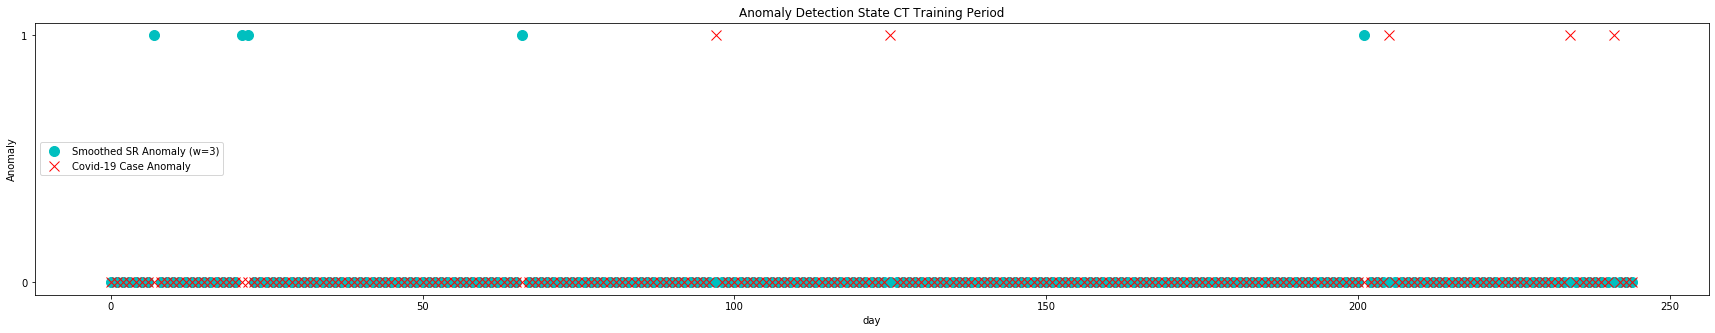

In [96]:
# precision, recall, Fscore
small_th = small_best_th_lag[CT][0]
small_lag = small_best_th_lag[CT][1]

L_CT_small = covid_case_outbreak_detection_all(actual_all_small, "CT")
L_hat_CT_small = pred_outbreak_detection(new_Sdelta_small, L_hat_period_small, small_th)

CT_S, L_window_CT = comparison_all("US-CT", L_CT_small, L_hat_CT_small, int(small_lag))


fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection State CT Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(L_hat_period_small)), L_hat_CT_small.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly (w=3)")
ax.plot(np.array(range(L_hat_period_small)), L_window_S, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

# Testing: Base

In [22]:
# Average delta of all days for each region
# delta mat shape (period, region)

def std_dev_delta(delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def L_score(delta_region, std_region, multiple):
    th = multiple * std_region
    L_score = delta_region > th
    return L_score.astype(int)

Base Smoothing

In [68]:
data_Jan = load('results/smoothing_delta/s3Jan21_02_31.npy')
data_Feb = load('results/smoothing_delta/s3Feb21_01_23.npy')

period_jan = data_Jan.shape[0]
period_feb = data_Feb.shape[0]
new_delta_Jan21 = new_delta_mat(data_Jan, period_jan, 4, 7)
new_delta_Feb21 = new_delta_mat(data_Feb, period_feb, 4, 7)
print("New delta created")


new_delta_testing = np.concatenate((new_delta_Jan21, new_delta_Feb21[:5]), axis=0)
testing_period = len(new_delta_testing)
print(testing_period, "days")

# Ave delta and Std Delta for Training period
test_std_mat = std_dev_delta(new_Sdelta)
print("Std mat shape", test_std_mat.shape)

New delta created
35 days
Std mat shape (51,)


In [69]:
actual_testing = actual_cases_testing[(actual_cases_testing.date >= "2020-03-07") & (actual_cases_testing.date <= "2021-03-31")]
print(actual_testing.date.nunique(), "days")

366 days


In [70]:
def comparison_test(L, L_hat_region, lag):
    period = len(L_hat_region) 
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

def test(test_delta, actual_testing, testing_period, std_mat, best_th_lag):
    f_score = np.zeros(NUM_STATES)
    TP_FP = np.zeros((NUM_STATES,2))
    FN = np.zeros(NUM_STATES)
    true_anomalies = np.zeros(NUM_STATES)
    
    for idx_s, state in enumerate(STATES):
        target = state[3:]
        L_test = covid_case_outbreak_detection_all(actual_testing, target)
        
        # Testing period start 2nd Jan
        L_test_p = L_test[302:]
        
        test_delta_region = test_delta.transpose()[idx_s]
        L_hat_testing = L_score(test_delta_region, std_mat[idx_s], best_th_lag[idx_s][0]) 
        
        S_test, L_window_test = comparison_test(L_test, L_hat_testing, int(best_th_lag[idx_s][1]))
        met = metrics(S_test, L_window_test)
        
        true_anomalies[idx_s] = np.sum(L_window_test)
        f_score[idx_s] = met[4]
        TP_FP[idx_s] = met[0]
        FN[idx_s] = met[1]
    return f_score, TP_FP, FN, true_anomalies

In [71]:
f_test, TP_FP_test, FN_test, L_window_sum = test(new_delta_testing, actual_testing, testing_period, test_std_mat, state_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


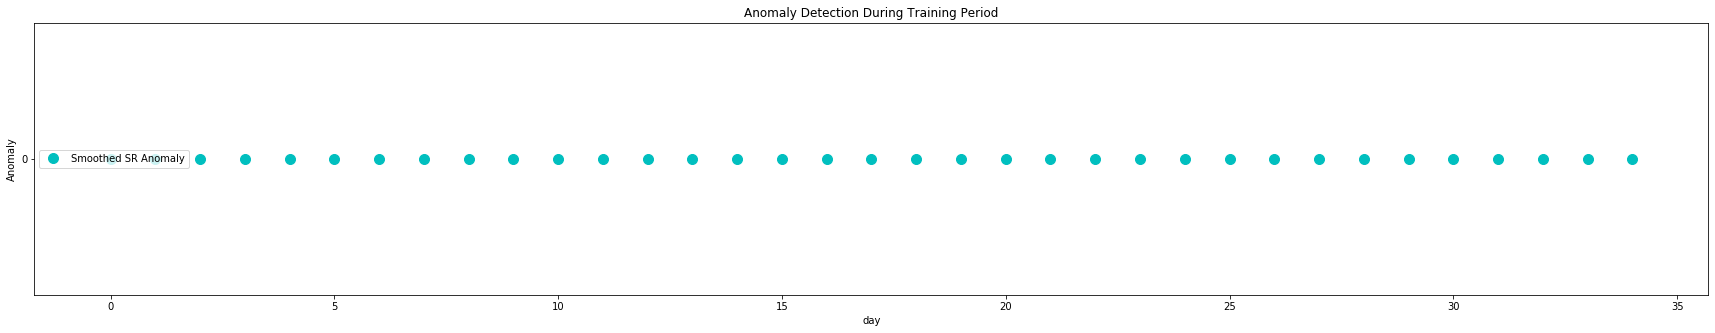

In [73]:
CT = get_target_region_idx("US-CT")
L_test = covid_case_outbreak_detection_all(actual_testing, "CT")
L_hat_testing = L_score(new_delta_testing.transpose()[CT], test_std_mat[CT], state_best_th_lag[CT][0]) 

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(testing_period)), L_hat_testing, marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
# ax.plot(np.array(range(testing_period)), L_test[302:330], marker='x',  markersize=10, color='r', linewidth=0, label="Smoothed SR Anomaly")
ax.legend(loc="center left")

In [74]:
state_best_th_lag[CT]

array([ 3.5, 26. ])

In [75]:
test_std_mat[CT]

0.05136749187248113

In [51]:
new_delta_testing.transpose()[CT][9]

0.006060807301471263

In [76]:
f_test

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.44444444,
              nan,        nan,        nan,        nan,        nan,
       0.22222222,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.5       ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

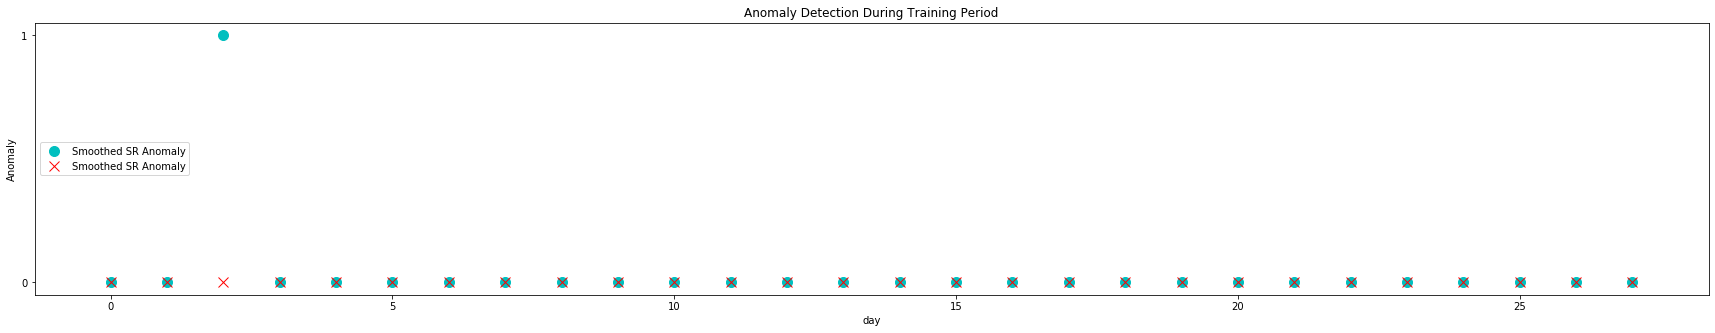

In [64]:
AZ = get_target_region_idx("US-AZ")
L_test = covid_case_outbreak_detection_all(actual_testing, "AZ")
L_hat_testing = L_score(new_delta_testing.transpose()[CT], test_std_mat[CT], state_best_th_lag[AZ][0]) 

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(testing_period)), L_hat_testing, marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(testing_period)), L_test[302:330], marker='x',  markersize=10, color='r', linewidth=0, label="Smoothed SR Anomaly")
ax.legend(loc="center left")